In [1]:
!pip install z3-solver

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from z3 import *
from itertools import combinations

In [3]:
instances_path = "../../instances/"
with open(instances_path + "ins-10.txt") as f:
    lines = [f[:-1] for f in f.readlines()]
    w, n = int(lines[0]), int(lines[1])
    b = [d.split() for d in lines[2:]]
    b = [(int(bw), int(bh)) for (bw, bh) in b]

In [4]:
b

[(3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 3),
 (4, 8),
 (4, 14),
 (7, 3),
 (7, 6)]

### Parameters
- $n$ number of blocks
- $B_i$, $i = 0, ..., n-1$ blocks to insert where $B_i = \{x_i, y_i\}$ are the dimensions of the $i$-block, weight and height respectively
- width $w$
- ```rot = True``` if rotation is allowed 

### Constraints:
- The blocks in the grid can't overlap (exactly one value for each cell). $\sum_{k=0}^{n}(\texttt{cells}_{i,j,k}) \leq 1 \land \sum_{k=0}^{n}(\texttt{cells}_{i,j,k}) \geq 1$ $\forall i,j=0,...,n-1 $
- The cell $\texttt{cells}_{i, j}$ is the bottom left border of one block and its surrounding cells must have the same $k$ value. Moreover, inserting a block mustn't enlarge the width $w$. $\texttt{exactly_one} \Big[ \huge{\land_{\small r=i}^{\small i+y_k} \land_{\small c=j}^{\small j+x_k}}$ $\Big( \texttt{cells}_{r,c,k} \land (j+x_k<w)  \land (i+y_k<h) \Big)$ $\forall i,j=0,...,n-1 \Big]$ $\forall k=0,...,n$

In [5]:
def vlsi_sat(n, b, w, rot=False):
    # b = (bw, bh)
    # left bottom coordinates of each placed block
    x = [Int(f"x_{i}") for i in range(len(b))]
    y = [Int(f"y_{i}") for i in range(len(b))]
    h = Int(f"h")
    
    o = Optimize()
    
    # x_i + bw_i < w and y_i + bh_i < h foreach i in [0, ..., len(b)]
    # x_i >= 0 and y_i >= 0 foreach i in [0, ..., len(b)]
    o.add([And(x[i] >= 0, x[i] + b[i][0] < w,
              y[i] >= 0, y[i] + b[i][1] < h) for i in range(len(b))])  
    
    #o.add([Or(
    #        Or(x[i] + b[i][0] <= x[j], x[j] + b[j][0] <= x[i]),
    #        Or(And(y[i] <= y[j], y[i] + b[i][1] <= y[j])))
    #     for (i, j) in combinations(range(len(b)), 2)])
    
    o.add([Or(
            Or(x[i] + b[i][0] <= x[j], x[j] + b[j][0] <= x[i]),
            Or(y[i] + b[i][1] <= y[j], y[j] + b[j][1] <= y[i]))
         for (i, j) in combinations(range(len(b)), 2)])
    o.minimize(h)
    
    o.check()
    if o.check() == sat:
        m = o.model()
        return (m.evaluate(h).as_long(),
                [(m.evaluate(x[i]).as_long(), m.evaluate(y[i]).as_long())
                for i in range(len(b))])
    return "UNSAT"

In [6]:
%%time
h, lfc = vlsi_sat(n, b, w)

CPU times: user 2.32 s, sys: 15.5 ms, total: 2.33 s
Wall time: 2.33 s


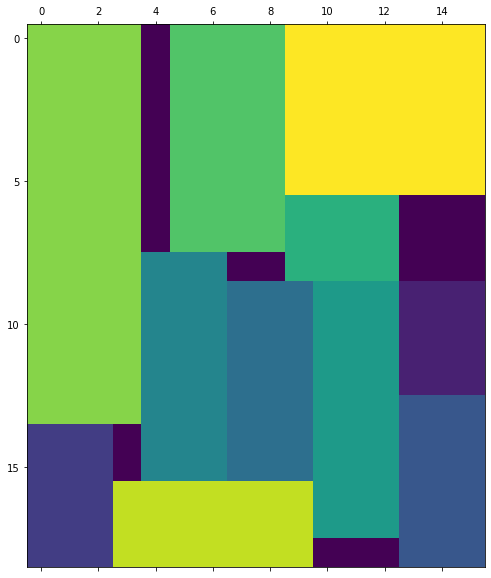

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

M = np.zeros((h - 1, w - 1))
for i, (x, y) in enumerate(lfc):
    M[y : y + b[i][1], x : x + b[i][0]] = i
    
M = np.flip(M)
ax.matshow(M);

In [8]:
h

20